In [3]:
import json

# Let's see if we can access the prediction for on image as an example for planning
master_json = "predictions_dict_master_fullnogeo.json"

with open(master_json, "r") as f:
    data = json.load(f)
    json_string = json.dumps(data['predictions'][1000], indent=3)

print(json_string)

{
   "filepath": "images/batch_0/5f8d58e8375a75c9f178c8d3a6e65293.jpg",
   "classifications": {
      "classes": [
         "f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank",
         "b1352069-a39c-4a84-a949-60044271c0c1;aves;;;;;bird",
         "990ae9dd-7a59-4344-afcb-1b7b21368000;mammalia;primates;hominidae;homo;sapiens;human",
         "aca65aaa-8c6d-4b69-94de-842b08b13bd6;mammalia;cetartiodactyla;bovidae;bos;taurus;domestic cattle",
         "fdc27cfb-3756-4794-992d-1d512f7c5474;mammalia;rodentia;sciuridae;cynomys;ludovicianus;arizona black-tailed prairie dog"
      ],
      "scores": [
         0.9997740387916565,
         4.6810757339699194e-05,
         2.226079232059419e-05,
         2.142155426554382e-05,
         1.4680168533232063e-05
      ]
   },
   "detections": [
      {
         "category": "3",
         "label": "vehicle",
         "conf": 0.027265893295407295,
         "bbox": [
            0.947214100509882,
            0.25,
            0.052785925567150116,
     

In [4]:
# Let's see if we can access the prediction for each image
_CONF = 0.3 # Master Setting for confidence or score threshold

# Function for pairing classification and score
def get_high_score_classes(scores, classes, threshold=_CONF):
    return [{"score": f'{score:.2f}', "class": cls} for score, cls in zip(scores, classes) if score > threshold]

# Function for pairing detection and score
def get_high_conf_detections(detections, target_label, threshold=_CONF):
    return [(f'{det["conf"]:2f}', det["label"]) for det in detections if det["label"] == target_label and det["conf"] > threshold]

# Staged Configuration
master_data = []

# Open and loop over json file
with open(master_json, "r") as f:
    data = json.load(f)
    for image in data["predictions"]:
        high_score_classes = get_high_score_classes(
            image["classifications"]["scores"],
            image["classifications"]["classes"],
            _CONF
        )
        master_data.append({
            "imageName": image["filepath"].split("/")[2],
            "nDetections_animal": len(get_high_conf_detections(image["detections"], "animal", _CONF)),
            "nDetections_human": len(get_high_conf_detections(image["detections"], "human", _CONF)),
            "nDetections_vehicle": len(get_high_conf_detections(image["detections"], "vehicle", _CONF)),
            "nClassifications": len(high_score_classes),
            "highScoreClasses": high_score_classes

        })
        
print(master_data[0:1])
    

[{'imageName': 'c89e327383d91bdaadda59e65c57eec8.jpg', 'nDetections_animal': 0, 'nDetections_human': 0, 'nDetections_vehicle': 0, 'nClassifications': 1, 'highScoreClasses': [{'score': '1.00', 'class': 'f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank'}]}]


In [5]:
# When ready, convert the list of dicts to a dataframe
import pandas as pd

# Create Dataframe
df = pd.DataFrame(master_data)

# Check Quality
print(f'{len(df)} Images in Dataset')
print(" Dataset Head ")
print(df.head())

104937 Images in Dataset
 Dataset Head 
                              imageName  nDetections_animal  \
0  c89e327383d91bdaadda59e65c57eec8.jpg                   0   
1  8071eb10b23bdda01af32fb564c6446b.jpg                   0   
2  62c2182b59a70270579d7aa09fab3e6c.jpg                   0   
3  956d8f9f18208168bb30bbac9299bb59.jpg                   0   
4  15eb3dca11fbd0e6cc8366ffd08ed8ec.jpg                   0   

   nDetections_human  nDetections_vehicle  nClassifications  \
0                  0                    0                 1   
1                  0                    0                 1   
2                  0                    0                 1   
3                  0                    0                 1   
4                  0                    0                 1   

                                    highScoreClasses  
0  [{'score': '1.00', 'class': 'f1856211-cfb7-4a5...  
1  [{'score': '0.98', 'class': 'f1856211-cfb7-4a5...  
2  [{'score': '0.99', 'class': 'f1856

In [6]:
# Now let's explode the classes tuples so we have a row per high confidence class - noting that the counts are not per class but for total detection type in image
df2 = df.explode("highScoreClasses", ignore_index=True)

# Normalize to flatten the dicts
class_df = pd.json_normalize(df2["highScoreClasses"])

# remove original column and join back to the df
df2 = df.join(class_df).drop(columns=["highScoreClasses"])

print(df2.head())

                              imageName  nDetections_animal  \
0  c89e327383d91bdaadda59e65c57eec8.jpg                   0   
1  8071eb10b23bdda01af32fb564c6446b.jpg                   0   
2  62c2182b59a70270579d7aa09fab3e6c.jpg                   0   
3  956d8f9f18208168bb30bbac9299bb59.jpg                   0   
4  15eb3dca11fbd0e6cc8366ffd08ed8ec.jpg                   0   

   nDetections_human  nDetections_vehicle  nClassifications score  \
0                  0                    0                 1  1.00   
1                  0                    0                 1  0.98   
2                  0                    0                 1  0.99   
3                  0                    0                 1  1.00   
4                  0                    0                 1  0.98   

                                             class  
0  f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank  
1  f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank  
2  f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;bl

In [7]:
# Make a custom column
df2["simple_class"] = df2["class"].str.split(";").str[-1]

df2.head()

,imageName,nDetections_animal,nDetections_human,nDetections_vehicle,nClassifications,score,class,simple_class
0,c89e327383d91bdaadda59e65c57eec8.jpg,0,0,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
1,8071eb10b23bdda01af32fb564c6446b.jpg,0,0,0,1,0.98,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
2,62c2182b59a70270579d7aa09fab3e6c.jpg,0,0,0,1,0.99,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
3,956d8f9f18208168bb30bbac9299bb59.jpg,0,0,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
4,15eb3dca11fbd0e6cc8366ffd08ed8ec.jpg,0,0,0,1,0.98,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank


In [8]:
# Save the df as a csv
df2.to_csv("classified_images.csv")

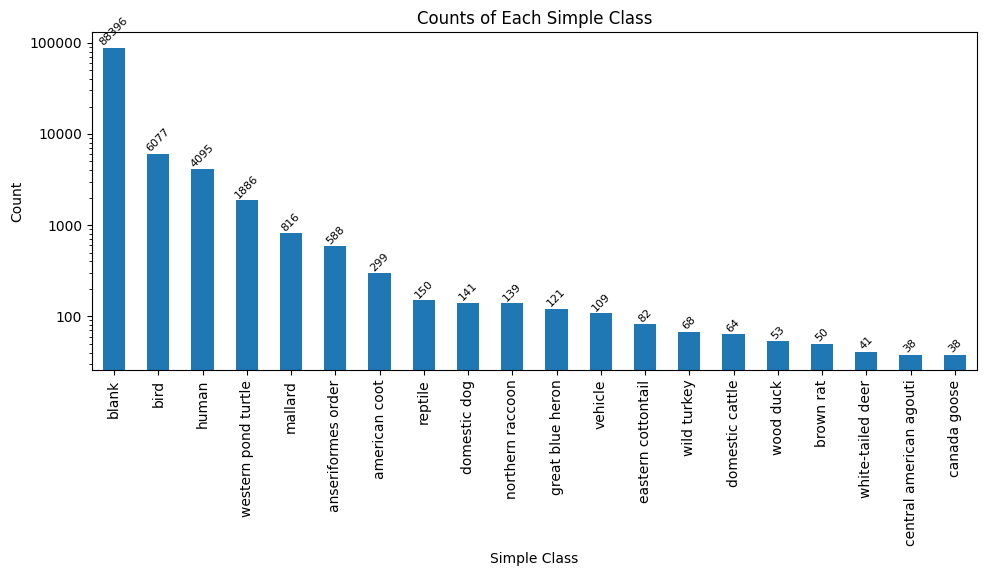

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Filter out a simple class
df3 = df2[~df2["simple_class"].isin([])]

# Count how many times each simple_class appears
counts = df3["simple_class"].value_counts()
counts = counts[:20]

# Plot bar graph
ax = counts.plot(kind="bar", figsize=(12,5))
plt.title("Counts of Each Simple Class")

# Configure y axis
plt.yscale("log")
plt.ylabel("Count")

# Format y-axis ticks as integers (not floats/scientific)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

# Configure x axis
plt.xlabel("Simple Class")
plt.xticks(rotation=90, ha="center")

# Add count labels on top of each bar, rotated vertical
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-position: center of bar
        height,                             # y-position: top of bar
        f'{int(height)}',                   # text: integer count
        ha='center',
        va='bottom',
        rotation=45,
        fontsize=8
    )


# Display
plt.tight_layout()
plt.subplots_adjust(bottom=0.25, left=0.25)
plt.show()


In [10]:
# Create a table of counts
counts_table = df3["simple_class"].value_counts().reset_index()
counts_table.columns = ["simple_class", "count"]

def format_pct(x):
    if x < 0.1: return f'{x:.3f}' 
    elif x < 1: return f'{x:.2f}' 
    else: return f'{x:.1f}'

counts_table["%"] = (counts_table["count"]/len(df3) * 100).map(format_pct)
counts_table.index = counts_table.index + 1

# Display the table
top_20_classes = counts_table[:20]
top_20_classes


,simple_class,count,%
1,blank,88396,84.2
2,bird,6077,5.8
3,human,4095,3.9
4,western pond turtle,1886,1.8
5,mallard,816,0.78
6,anseriformes order,588,0.56
7,american coot,299,0.28
8,reptile,150,0.14
9,domestic dog,141,0.13
10,northern raccoon,139,0.13


In [24]:
# Create a mediaID column by splitting on '.' and taking the first part
df3['mediaID'] = df3['imageName'].str.split('.').str[0]
df3.head()

,imageName,nDetections_animal,nDetections_human,nDetections_vehicle,nClassifications,score,class,simple_class,mediaID
0,c89e327383d91bdaadda59e65c57eec8.jpg,0,0,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank,c89e327383d91bdaadda59e65c57eec8
1,8071eb10b23bdda01af32fb564c6446b.jpg,0,0,0,1,0.98,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank,8071eb10b23bdda01af32fb564c6446b
2,62c2182b59a70270579d7aa09fab3e6c.jpg,0,0,0,1,0.99,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank,62c2182b59a70270579d7aa09fab3e6c
3,956d8f9f18208168bb30bbac9299bb59.jpg,0,0,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank,956d8f9f18208168bb30bbac9299bb59
4,15eb3dca11fbd0e6cc8366ffd08ed8ec.jpg,0,0,0,1,0.98,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank,15eb3dca11fbd0e6cc8366ffd08ed8ec


In [25]:
# Let's rejoin the test medias and predictions based on imageName

metadata = pd.read_csv("ur_test_medias.csv")
predicts = df3.copy()

print(" ======== df('METADATA') ======== ")
metadata.info()

print(" ======== df('PREDICTS') ======== ")
predicts.info()

 ======== df('METADATA') ======== 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105163 entries, 0 to 105162
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   mediaID     105163 non-null  object
 1   timestamp   105163 non-null  object
 2   publicURL   105163 non-null  object
 3   fileName    105163 non-null  object
 4   folderName  105163 non-null  object
dtypes: object(5)
memory usage: 4.0+ MB
 ======== df('PREDICTS') ======== 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104937 entries, 0 to 104936
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   imageName            104937 non-null  object
 1   nDetections_animal   104937 non-null  int64 
 2   nDetections_human    104937 non-null  int64 
 3   nDetections_vehicle  104937 non-null  int64 
 4   nClassifications     104937 non-null  int64 
 5   score                103581 

In [26]:
# Merge them based on a column name (a join would be on the index and not appropriate in this case)
merged_df = pd.merge(metadata, predicts, on="mediaID", how="inner")

print(len(predicts))
print(len(merged_df))

with pd.option_context('display.max_colwidth', None):
    display(merged_df.tail())

merged_df.to_csv('merged_df.csv')


104937
105162


,mediaID,timestamp,publicURL,fileName,folderName,imageName,nDetections_animal,nDetections_human,nDetections_vehicle,nClassifications,score,class,simple_class
105157,113f9bb59e434d5e52dc6ee63efb39b0,2024-12-25 15:29:24,https://urbanriverrangers.s3.amazonaws.com/images/2025/2025-01-04_UR027/DCIM/100MEDIA/SYFW01868.jpg,SYFW01868.jpg,2025-01-04_UR027,113f9bb59e434d5e52dc6ee63efb39b0.jpg,0,1,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
105158,871315ba0ab9f2958417e2a6533cd6de,2024-12-25 15:29:24,https://urbanriverrangers.s3.amazonaws.com/images/2025/2025-01-04_UR027/DCIM/100MEDIA/SYFW01869.jpg,SYFW01869.jpg,2025-01-04_UR027,871315ba0ab9f2958417e2a6533cd6de.jpg,0,1,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
105159,991baedeb69e7459d6bd6813c041a9db,2024-12-25 15:29:24,https://urbanriverrangers.s3.amazonaws.com/images/2025/2025-01-04_UR027/DCIM/100MEDIA/SYFW01870.jpg,SYFW01870.jpg,2025-01-04_UR027,991baedeb69e7459d6bd6813c041a9db.jpg,0,1,0,1,0.68,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
105160,32c8912bf29b67263f4f5c416ae6f68c,2024-12-25 15:29:26,https://urbanriverrangers.s3.amazonaws.com/images/2025/2025-01-04_UR027/DCIM/100MEDIA/SYFW01871.jpg,SYFW01871.jpg,2025-01-04_UR027,32c8912bf29b67263f4f5c416ae6f68c.jpg,0,0,0,1,0.97,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank
105161,f4ba4a3d6ad961a852cb5bccd2f08d0a,2024-12-25 15:29:26,https://urbanriverrangers.s3.amazonaws.com/images/2025/2025-01-04_UR027/DCIM/100MEDIA/SYFW01872.jpg,SYFW01872.jpg,2025-01-04_UR027,f4ba4a3d6ad961a852cb5bccd2f08d0a.jpg,0,0,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank


## Where nothing was detected - was something in the shot?

For images where classification was missing - pulling a random set and looking to see if there was really nothing

In [27]:
# Let's take a look at images where classifications is NaN
from IPython.display import Image, display, HTML
import random

nan_class_df = merged_df[ (merged_df["nClassifications"] == 0) & (merged_df["nDetections_animal"] == 0)]

# pick a subset of 5
sampled_df = nan_class_df.sample(n=9, random_state=42)  # set seed for reproducibility

# Create HTML to display images in a grid
html_str = '<div style="max-width: 900px; display: flex; flex-wrap: wrap; gap: 10px;">'

for i, row in sampled_df.iterrows():
    url = row["publicURL"]
    caption = f'{row["folderName"]}| n_ani: {row["nDetections_animal"]}, n_hum: {row["nDetections_human"]}, n_veh: {row["nDetections_vehicle"]}'

    img_html = f'''
    <div style="flex: 1 0 30%; text-align: left;">
        <div style="margin-top: 4px; font-size: 12px; color: #ccc">{caption}</div>
        <a href="{url}" target="_blank">
            <img src="{url}" style="max-width: 100%; height: auto; max-height: 150px; border: 1px solid #ccc;"/>
        </a>
    </div>
    '''
    html_str += img_html

html_str += '</div>'

display(HTML(html_str))


Clearly there are some mistakes  
There are 3 photos in this "no animals detected" set that very much have animals in them - and some cute ones too!

## What is being labeled as an American Coot?

In [28]:
# Let's take a look at images where classifications is NaN
from IPython.display import Image, display, HTML
import random

coot_class_df = merged_df[ (merged_df["simple_class"] == "american coot")]
print(f'N coot class: {len(coot_class_df)}')

# pick a subset of 5
sampled_df = coot_class_df.sample(n=9, random_state=42)  # set seed for reproducibility

# Create HTML to display images in a grid
html_str = '<div style="max-width: 900px; display: flex; flex-wrap: wrap; gap: 10px;">'

for i, row in sampled_df.iterrows():
    url = row["publicURL"]
    caption = f'{row["folderName"]}| class: {row["simple_class"]}'

    img_html = f'''
    <div style="flex: 1 0 30%; text-align: left;">
        <div style="margin-top: 4px; font-size: 12px; color: #ccc">{caption}</div>
        <a href="{url}" target="_blank">
            <img src="{url}" style="max-width: 100%; height: auto; max-height: 150px; border: 1px solid #ccc;"/>
        </a>
    </div>
    '''
    html_str += img_html

html_str += '</div>'

display(HTML(html_str))


N coot class: 299


In [29]:
# Let's take a look at images where classifications is NaN
from IPython.display import Image, display, HTML
import random

gbh_class_df = merged_df[ (merged_df["simple_class"] == "great blue heron")&merged_df['score']>0.99]
print(f'N gbh class: {len(gbh_class_df)}')

# pick a subset of 5
sampled_df = gbh_class_df.sample(n=9, random_state=42)  # set seed for reproducibility

# Create HTML to display images in a grid
html_str = '<div style="max-width: 900px; display: flex; flex-wrap: wrap; gap: 10px;">'

for i, row in sampled_df.iterrows():
    url = row["publicURL"]
    caption = f'{row["folderName"]}| class: {row["simple_class"]}'

    img_html = f'''
    <div style="flex: 1 0 30%; text-align: left;">
        <div style="margin-top: 4px; font-size: 12px; color: #ccc">{caption}</div>
        <a href="{url}" target="_blank">
            <img src="{url}" style="max-width: 100%; height: auto; max-height: 150px; border: 1px solid #ccc;"/>
        </a>
    </div>
    '''
    html_str += img_html

html_str += '</div>'

display(HTML(html_str))


N gbh class: 121


Shoot - there is noot any coots

### A Quick Single Image Finder

In [26]:
# Let's take a look at images where classifications is NaN
from IPython.display import Image, display, HTML
import random

single_search = merged_df[ (merged_df["imageName"] == "2024-06-18_UR003--DSCF0027.JPG")]

# Create HTML to display images in a grid
html_str = '<div style="max-width: 900px; display: flex; flex-wrap: wrap; gap: 10px;">'

for i, row in single_search.iterrows():
    url = row["publicURL"]
    caption = f'{row["folderName"]}| class: {row["simple_class"]}'

    img_html = f'''
    <div style="flex: 1 0 30%; text-align: left;">
        <div style="margin-top: 4px; font-size: 12px; color: #ccc">{caption}</div>
        <a href="{url}" target="_blank">
            <img src="{url}" style="max-width: 100%; height: auto; max-height: 150px; border: 1px solid #ccc;"/>
        </a>
    </div>
    '''
    html_str += img_html

html_str += '</div>'

display(HTML(html_str))


## Time for some EDA statistics

Shape, Nulls, Summaries, Duplicates Etc


In [15]:
# Let's explore the merged df
import numpy as np
# import pandas as pd # Already imported above, uncomment if starting over here.
import seaborn as sns
import matplotlib.pyplot as plt

# Overview of shape
print("============== Shape ==============") 
rows, cols = merged_df.shape
print(f'Rows: {rows}, Cols: {cols}')

# Data types and non-null counts
print("\n============== Info ==============") 
merged_df.info()

# Peek at the first few rows
print("\n============== Head ==============")
#temporaly set expand_frame_repr
with pd.option_context('expand_frame_repr', False):
    print(merged_df.head())

# Basic summary stats (numeric columns only)
print("\n============== Describe ==============")
with pd.option_context('expand_frame_repr', False):
    print(merged_df.describe())



============== Shape ==============
Rows: 111982, Cols: 12

============== Info ==============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111982 entries, 0 to 111981
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   timestamp            111982 non-null  object
 1   publicURL            111982 non-null  object
 2   fileName             111982 non-null  object
 3   folderName           111982 non-null  object
 4   imageName            111982 non-null  object
 5   nDetections_animal   111982 non-null  int64 
 6   nDetections_human    111982 non-null  int64 
 7   nDetections_vehicle  111982 non-null  int64 
 8   nClassifications     111982 non-null  int64 
 9   score                110512 non-null  object
 10  class                110512 non-null  object
 11  simple_class         110512 non-null  object
dtypes: int64(4), object(8)
memory usage: 10.3+ MB

============== Head ==============
       

In [16]:
# Total missing values per column
print("\nMissing values:")
print(merged_df.isnull().sum())

# Percentage of missing values
print("\nMissing value %:")
print((merged_df.isnull().mean() * 100).sort_values(ascending=False))



Missing values:
timestamp                 0
publicURL                 0
fileName                  0
folderName                0
imageName                 0
nDetections_animal        0
nDetections_human         0
nDetections_vehicle       0
nClassifications          0
score                  1470
class                  1470
simple_class           1470
dtype: int64

Missing value %:
simple_class           1.312711
score                  1.312711
class                  1.312711
timestamp              0.000000
folderName             0.000000
fileName               0.000000
publicURL              0.000000
imageName              0.000000
nDetections_vehicle    0.000000
nDetections_human      0.000000
nDetections_animal     0.000000
nClassifications       0.000000
dtype: float64


For those score, class, and simple class that are missing - this is expected because the three columns are all related from root:  
"score: {score}, class: {class}" and simple_class is {class}[-1]

C:\Users\mores\AppData\Local\Temp\ipykernel_3364\4219143720.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.isnull().sum())


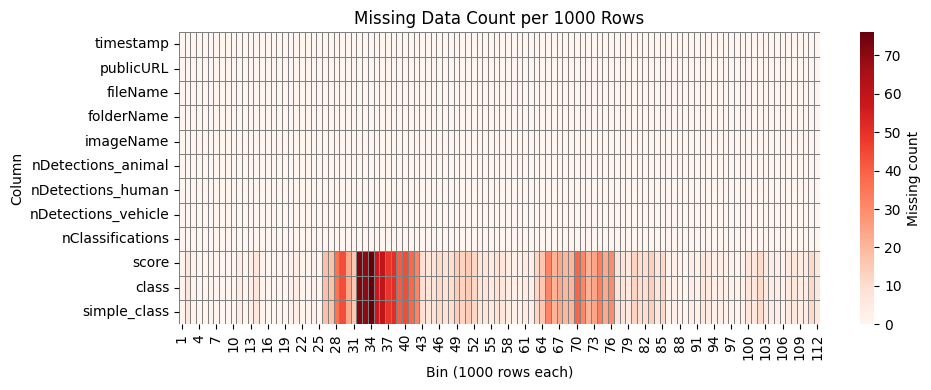

In [17]:
# Create a bin index for every 1000 rows
bin_size = 1000
# n_bins = int(np.ceil(len(merged_df) / bin_size))
merged_df['bin'] = (np.arange(len(merged_df)) // bin_size) + 1

# Count missing values per column for each bin
missing_per_bin = (
    merged_df
    .groupby('bin')
    .apply(lambda x: x.isnull().sum())
    .drop(columns='bin')
)

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(missing_per_bin.T, cmap="Reds", cbar_kws={'label': 'Missing count'}, linewidths=0.5, linecolor='gray')
plt.xlabel("Bin (1000 rows each)")

plt.ylabel("Column")
plt.title("Missing Data Count per 1000 Rows")
plt.tight_layout()
plt.show()

That the system struggled heavily with images in the 27k to 37k rows might indicate that the photos in one or more specific folders has an issue -  

For example, we know that at some point the small size image preview files were uploaded (the snapshots generally used in the app)  

Let's grab the URL path on a subset of these to confirm

In [18]:
# missing class subset
missing_class_urls = merged_df[merged_df['class'].isnull()]["publicURL"]

with pd.option_context('display.max_colwidth', None):
  print(missing_class_urls)


546       https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-02-01_16-41-42/DCIM/100SYCAM/SYEW0304.JPG
1022      https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-02-01_16-41-42/DCIM/100SYCAM/SYEW0937.JPG
1388      https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-02-01_16-41-42/DCIM/100SYCAM/SYEW1424.JPG
1466      https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-02-01_16-41-42/DCIM/100SYCAM/SYEW1528.JPG
1513      https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-02-01_16-41-42/DCIM/100SYCAM/SYEW1588.JPG
                                                          ...                                                  
111477       https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-11-21_UR011/DCIM/100MEDIA/SYFW2278.JPG
111521       https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-11-21_UR011/DCIM/100MEDIA/SYFW2337.JPG
111715      https://urbanriverrangers.s3.amazonaws.com/images/2025/2025-01-04_UR027/DCIM/100MEDIA/SYFW01

At first glance - these do not appear to be only related to clips or small resolution images - so in the mix there are truly no classes and some missed animals.

In [19]:
# Number of exact duplicates
duplicates = merged_df.duplicated()
print("Duplicate rows:", duplicates.sum())

# Optionally remove them
# merged_df = merged_df.drop_duplicates()



Duplicate rows: 1003


In [20]:
# Unique values per column (categorical)
for col in merged_df.select_dtypes(include='object'):
    print(f"\nColumn '{col}' unique values:")
    print(merged_df[col].value_counts(dropna=False))



Column 'timestamp' unique values:
timestamp
2025-01-05 08:04:34    16
2024-06-07 14:51:52     6
2024-06-07 15:39:03     6
2024-06-04 13:02:11     6
2024-06-07 14:24:47     6
                       ..
2023-12-20 10:45:46     1
2023-12-20 10:46:07     1
2023-12-20 10:46:14     1
2023-12-20 10:46:28     1
2024-09-10 16:02:55     1
Name: count, Length: 91235, dtype: int64

Column 'publicURL' unique values:
publicURL
https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW3637.JPG    2
https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW3638.JPG    2
https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW3640.JPG    2
https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW3641.JPG    2
https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/101SYCAM/SYEW3081.JPG    2
                                                


Highly correlated features (>0.8):
Empty DataFrame
Columns: []
Index: []


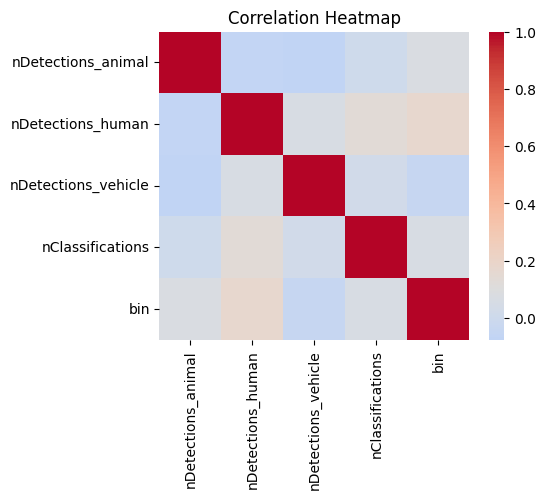

In [21]:
# Correlation matrix
corr_matrix = merged_df.select_dtypes(include='number').corr()

# Strong correlations (excluding 1.0)
strong_corr = corr_matrix[(abs(corr_matrix) > 0.8) & (abs(corr_matrix) < 1.0)]
print("\nHighly correlated features (>0.8):")
print(strong_corr.dropna(how='all').dropna(axis=1, how='all'))

# Visualize
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0.1)
plt.title("Correlation Heatmap")
plt.show()


In [22]:
# Convert the timstamp to datetime
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], errors='coerce')


print(merged_df.info())

merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111982 entries, 0 to 111981
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   timestamp            111982 non-null  datetime64[ns]
 1   publicURL            111982 non-null  object        
 2   fileName             111982 non-null  object        
 3   folderName           111982 non-null  object        
 4   imageName            111982 non-null  object        
 5   nDetections_animal   111982 non-null  int64         
 6   nDetections_human    111982 non-null  int64         
 7   nDetections_vehicle  111982 non-null  int64         
 8   nClassifications     111982 non-null  int64         
 9   score                110512 non-null  object        
 10  class                110512 non-null  object        
 11  simple_class         110512 non-null  object        
 12  bin                  111982 non-null  int64         
dtypes: datetime64[

,timestamp,publicURL,fileName,folderName,imageName,nDetections_animal,nDetections_human,nDetections_vehicle,nClassifications,score,class,simple_class,bin
0,2024-01-27 13:33:15,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0060.JPG,2024-01-30_prologis_02,2024-01-30_prologis_02--SYFW0060.JPG,0,1,0,1,0.99,990ae9dd-7a59-4344-afcb-1b7b21368000;mammalia;...,human,1
1,2024-01-24 18:56:50,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0001.JPG,2024-01-30_Learnin_platform_camera_test,2024-01-30_Learnin_platform_camera_test--SYFW0...,0,0,0,1,0.99,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank,1
2,2024-01-24 19:01:54,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0002.JPG,2024-01-30_Learnin_platform_camera_test,2024-01-30_Learnin_platform_camera_test--SYFW0...,0,1,0,1,0.99,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank,1
3,2024-01-24 19:03:05,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0004.JPG,2024-01-30_Learnin_platform_camera_test,2024-01-30_Learnin_platform_camera_test--SYFW0...,0,1,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank,1
4,2024-01-24 19:04:19,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0006.JPG,2024-01-30_Learnin_platform_camera_test,2024-01-30_Learnin_platform_camera_test--SYFW0...,0,1,0,1,1.00,f1856211-cfb7-4a5b-9158-c0f72fd09ee6;;;;;;blank,blank,1


In [23]:
# Let's split out time info so we can segment observations
merged_df['year'] = merged_df['timestamp'].dt.year
merged_df['month'] = merged_df['timestamp'].dt.month
merged_df['day'] = merged_df['timestamp'].dt.day
merged_df['hour'] = merged_df['timestamp'].dt.hour
merged_df['minute'] = merged_df['timestamp'].dt.minute
merged_df['second'] = merged_df['timestamp'].dt.second
merged_df['weekday'] = merged_df['timestamp'].dt.day_name()

# also make a shorthand weekday by recoding weekdays
weekday_map = {'Monday': 'Mon', 'Tuesday': 'Tue', 'Wednesday': 'Wed', 'Thursday': 'Thu', 'Friday': 'Fri', 'Saturday': 'Sat', 'Sunday': 'Sun'}

merged_df['weekday_short'] = merged_df['weekday'].map(weekday_map)


merged_df.head()

,timestamp,publicURL,fileName,folderName,imageName,nDetections_animal,nDetections_human,nDetections_vehicle,nClassifications,score,...,simple_class,bin,year,month,day,hour,minute,second,weekday,weekday_short
0,2024-01-27 13:33:15,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0060.JPG,2024-01-30_prologis_02,2024-01-30_prologis_02--SYFW0060.JPG,0,1,0,1,0.99,...,human,1,2024,1,27,13,33,15,Saturday,Sat
1,2024-01-24 18:56:50,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0001.JPG,2024-01-30_Learnin_platform_camera_test,2024-01-30_Learnin_platform_camera_test--SYFW0...,0,0,0,1,0.99,...,blank,1,2024,1,24,18,56,50,Wednesday,Wed
2,2024-01-24 19:01:54,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0002.JPG,2024-01-30_Learnin_platform_camera_test,2024-01-30_Learnin_platform_camera_test--SYFW0...,0,1,0,1,0.99,...,blank,1,2024,1,24,19,1,54,Wednesday,Wed
3,2024-01-24 19:03:05,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0004.JPG,2024-01-30_Learnin_platform_camera_test,2024-01-30_Learnin_platform_camera_test--SYFW0...,0,1,0,1,1.00,...,blank,1,2024,1,24,19,3,5,Wednesday,Wed
4,2024-01-24 19:04:19,https://urbanriverrangers.s3.amazonaws.com/ima...,SYFW0006.JPG,2024-01-30_Learnin_platform_camera_test,2024-01-30_Learnin_platform_camera_test--SYFW0...,0,1,0,1,1.00,...,blank,1,2024,1,24,19,4,19,Wednesday,Wed


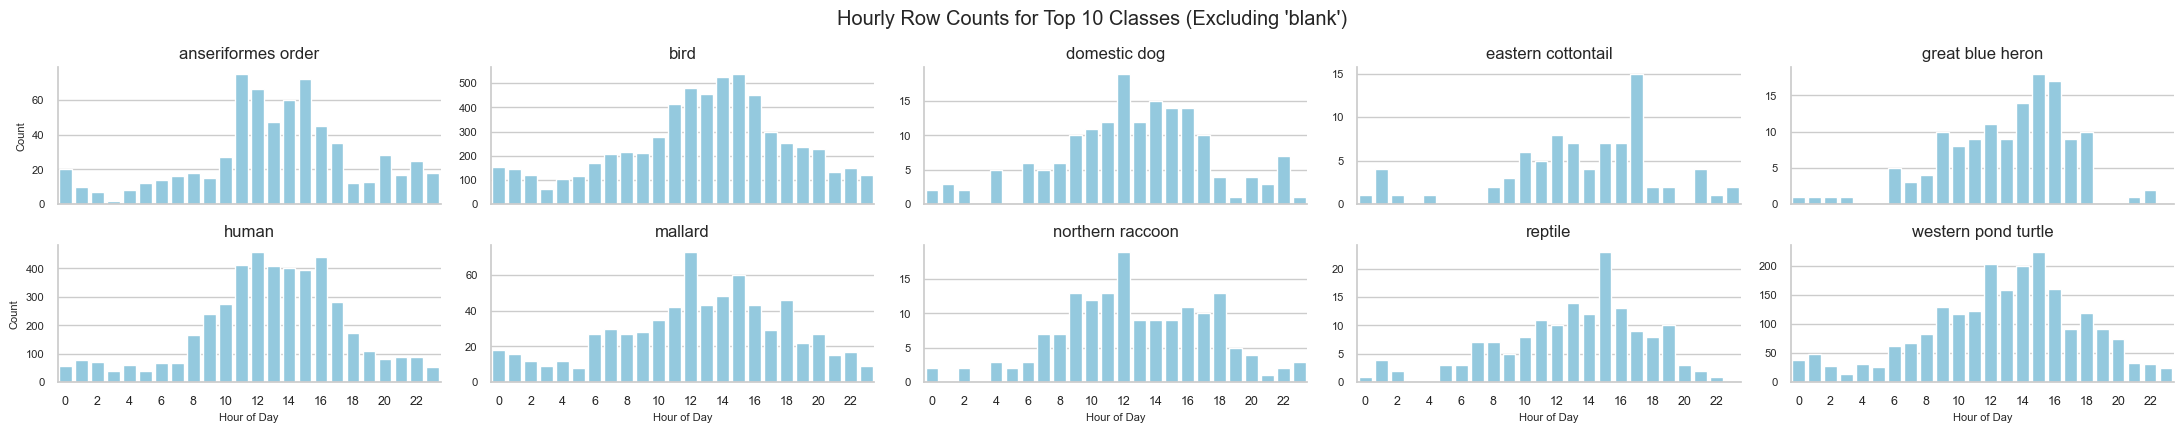

In [24]:
# Filter to top classes
filtered_df = merged_df[~merged_df['simple_class'].isin(['blank', 'american coot', 'vehicle'])].copy()

# top 10 classes
top_classes = filtered_df['simple_class'].value_counts().head(10).index

# Filter to top 10 classes only
top_df = filtered_df[filtered_df['simple_class'].isin(top_classes)]

# Group by class and hour
grouped = (top_df.groupby(['simple_class', 'hour']).size().reset_index(name='count'))

# Plot: one subplot per class
sns.set(style="whitegrid")
g = sns.FacetGrid(grouped, col='simple_class', col_wrap=5, height=2.2, aspect=2, sharey=False, sharex=True)

g.map_dataframe(sns.barplot, x='hour', y='count', color='skyblue', order=range(24))
g.set_titles(col_template="{col_name}", fontsize=8)
g.set_axis_labels("Hour of Day", "Count", fontsize=8)

# Ensure x-axis ticks are visible and readable
for ax in g.axes.flatten():
    ax.set_xlabel("Hour of Day", fontsize=8)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels([str(h) for h in range(0, 24, 2)], rotation=0)

g.tight_layout()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Hourly Row Counts for Top 10 Classes (Excluding 'blank')")
plt.show()

# birds and anseriformed (geese) show up mid day to early afternoon
In fact, each animal species tends to have an abundance shift to early in the afternoon between 15 to 19 hours ( 3 to 7pm )
Some braver species show up around noon and continue utnil about 7pm.

Same graph, but standardizing the axes to see relative abundance.

C:\Users\mores\AppData\Local\Temp\ipykernel_21480\123967348.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack()


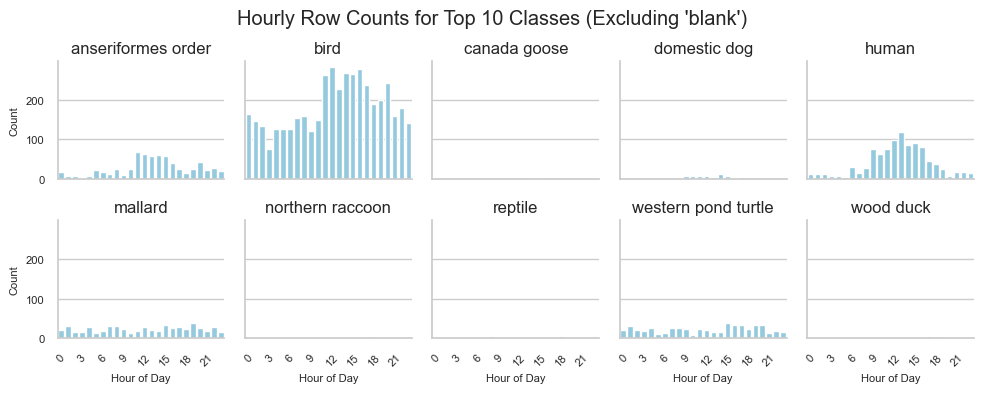

In [24]:
# Ensure all hour values (0–23) exist per class (fill missing with 0)
all_hours = pd.DataFrame({'hour': range(24)})
grouped_complete = (
    grouped
    .set_index(['simple_class', 'hour'])
    .unstack(fill_value=0)
    .stack()
    .reset_index()
    .rename(columns={0: 'count'})
)

# Set style and shared y-axis
sns.set(style="whitegrid")
g = sns.FacetGrid(
    grouped_complete,
    col='simple_class',
    col_wrap=5,
    height=2,
    sharey=True
)

# Plot bars with consistent x-axis ordering
g.map_dataframe(
    sns.barplot,
    x='hour',
    y='count',
    color='skyblue',
    order=list(range(24))
)

# Set titles and axis labels
g.set_titles(col_template="{col_name}", fontsize=8)
g.set_axis_labels("Hour of Day", "Count", fontsize=8)

# Ensure x-axis ticks are visible and readable
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xticks(range(0, 24, 3))
    ax.set_xticklabels([str(h) for h in range(0, 24, 3)], rotation=45)

# Layout adjustments
g.tight_layout()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Hourly Row Counts for Top 10 Classes (Excluding 'blank')")
plt.show()

# There are definitely birds being detected at all times of day
anseriformed order is geese
in bird we find geese, other small birds, ducks, and the occasional off target
humans follow a normal pattern of activity peaking around noon

mallard specific happens all day with slight evening increase
western pond turtle happens all day with slight evening increase

Let's graph the top 10 classes by species - and show the total counts by day of week ( not normalized, just total )

<function matplotlib.pyplot.show(close=None, block=None)>

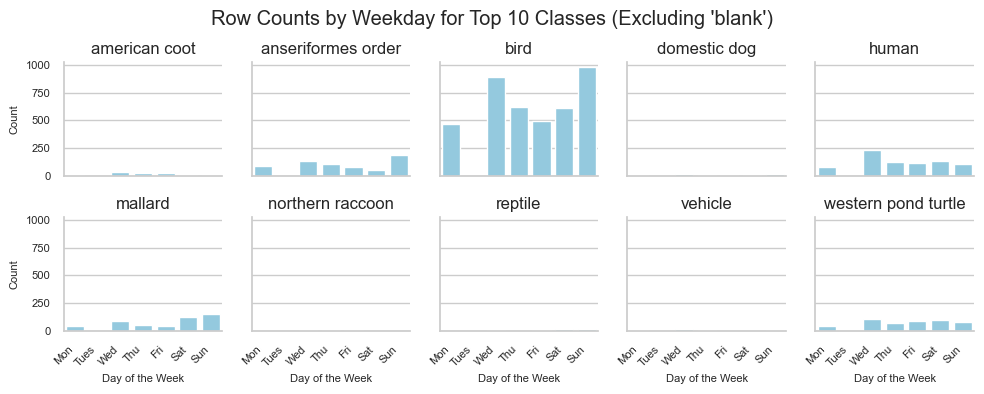

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out 'blank' class
filtered_df = merged_df[~merged_df['simple_class'].isin(['blank'])].copy()


# Get top 10 classes
top_classes = filtered_df['simple_class'].value_counts().head(10).index

# Filter to top classes
top_df = filtered_df[filtered_df['simple_class'].isin(top_classes)]

# Group and count rows by class and weekday
grouped = (
    top_df
    .groupby(['simple_class', 'weekday_short'])
    .size()
    .reset_index(name='count')
)

# Ensure all 7 weekdays exist for each class
weekday_order = ['Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
grouped['weekday_short'] = pd.Categorical(grouped['weekday_short'], categories=weekday_order, ordered=True)

# Plot
sns.set(style="whitegrid")
g = sns.FacetGrid(
    grouped,
    col='simple_class',
    col_wrap=5,
    height=2,
    sharey=True
)

g.map_dataframe(
    sns.barplot,
    x='weekday_short',
    y='count',
    color='skyblue',
    order=weekday_order
)

for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

g.set_titles(col_template="{col_name}", fontsize=8)
g.set_axis_labels("Day of the Week", "Count", fontsize=8)



g.tight_layout()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Row Counts by Weekday for Top 10 Classes (Excluding 'blank')")
plt.show
